In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import ast
from itertools import chain
import string
import os
from tqdm import tqdm

from sentence_transformers import SentenceTransformer ## need: pip install -U sentence-transformers

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [1]:
! pip install openai==0.28

  Using cached openai-0.28.0-py3-none-any.whl.metadata (13 kB)
  Using cached aiohttp-3.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.4 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached frozenlist-1.4.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached yarl-1.9.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
Using cached openai-0.28.0-py3-none-any.whl (76 kB)
Using cached aiohttp-3.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
Using cached async_timeout-4.0.3-py3-none-any.whl (5.7 kB)
Using cached frozenlist-1.4.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86

# Data Overview

In [3]:
parent_dir = os.path.dirname(os.getcwd())
data = pd.read_csv(os.path.join(parent_dir, "raw_data", "RAW_recipes.csv"))

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [5]:
data.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


# Data Cleaning

In [6]:
# Change Ingredients column from a string into a real list
data['ingredients'] = data['ingredients'].apply(ast.literal_eval)

In [7]:
%time 

# Concatenating ingredients into one string
data['ingredients_concat'] = data['ingredients'].apply(lambda x: ' '.join(x))


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.58 µs


In [8]:
# Take out punctuation from text
def clean_punctation(text):
    for punctuation in string.punctuation:
        mypunctuation = '!"#$%&\()*+,./:;<=>?@[\\]^_`{|}~'
        text = text.replace(punctuation, '')
    return text

data['ingredients_concat'] = data['ingredients_concat'].apply(lambda x: clean_punctation(x))

# Embedding via S-BERT

In [9]:
# Load S-BERT to create embedding
model = SentenceTransformer("all-MiniLM-L6-v2")


In [10]:
%%time

embeddings = model.encode(data['ingredients_concat'])

CPU times: user 1h 35min 24s, sys: 3min 20s, total: 1h 38min 45s
Wall time: 26min 39s


In [11]:
embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True)

In [12]:
# Save embeddings
import pickle

# Export Pipeline as le file
with open("embeddings_all_save.pkl", "wb") as file:
    pickle.dump(embeddings, file)



In [11]:
os.getcwd()

'/home/fmarat75/code/diogovicentesantos/Project_Le_Wagon/notebooks'

In [12]:
# Load Pipeline from pickle file
import pickle
embeddings = pickle.load(open("embeddings_all_save.pkl","rb"))

In [13]:
embeddings.shape

(231637, 384)

# Clustering recipes

In [119]:
data_slim = data.head(10000)

In [133]:
data_slim['ingredients_embedding'] = list(embeddings)

/tmp/ipykernel_1144/2442006680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_slim['ingredients_embedding'] = list(embeddings)


In [138]:
X = data_slim['ingredients_embedding'] 

## Kmeans

In [235]:
# Fit K-means
km = KMeans(n_clusters=100, )

km.fit(embeddings)

KMeans(n_clusters=100)

In [236]:
km.labels_

array([12, 24, 99, ..., 70, 70, 70], dtype=int32)

In [240]:
%%time

inertias = []
ks = range(1000, 2000, 100)

for k in ks:
    km_test = KMeans(n_clusters=k).fit(embeddings)
    inertias.append(km_test.inertia_)

CPU times: user 10min 23s, sys: 17min 39s, total: 28min 3s
Wall time: 3min 52s


In [241]:
inertias

[2476.636962890625,
 2407.54296875,
 2356.63330078125,
 2307.08056640625,
 2251.59375,
 2200.72021484375,
 2146.7890625,
 2098.627197265625,
 2047.466064453125,
 2004.9959716796875]

<AxesSubplot:>

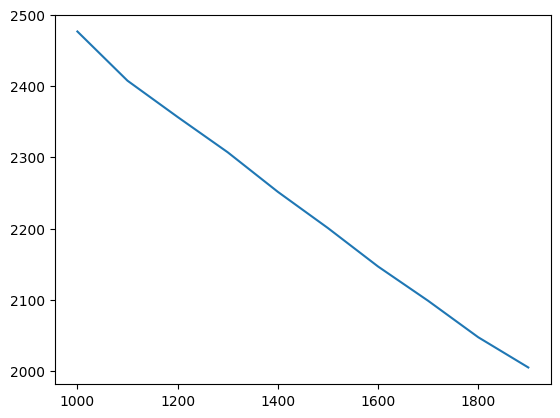

In [242]:
sns.lineplot(y = inertias, x = list(ks))

In [ ]:
data

## Nearest Neighbors + DBSCAN

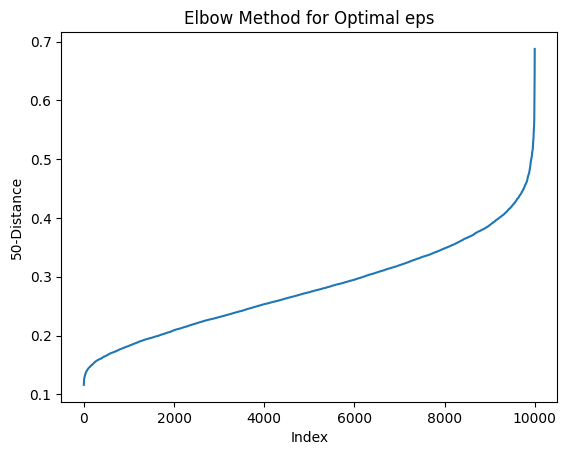

In [194]:
def find_optimal_eps(embeddings, k=4):
    neighbors = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    neighbors_fit = neighbors.fit(embeddings)
    distances, _ = neighbors_fit.kneighbors(embeddings)
    sorted_distances = np.sort(distances[:, -1], axis=0)

    plt.plot(sorted_distances)
    plt.xlabel('Index')
    plt.ylabel(f'{k}-Distance')
    plt.title(f'Elbow Method for Optimal eps')
    plt.show()

# Call the function
find_optimal_eps(embeddings, k=50)

In [209]:
def detect_clusters_dbscan(embeddings, eps=0.01, min_samples=50):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    cluster_labels = dbscan.fit_predict(embeddings)
    unique_communities = []
    for label in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == label)[0]
        if len(cluster_indices) >= min_samples:
            unique_communities.append(cluster_indices.tolist())
    return cluster_labels, unique_communities

# Call the function
cluster_labels, uniques_comm = detect_clusters_dbscan(embeddings, eps=0.3, min_samples=30)

In [210]:
len(cluster_labels)

10000

In [221]:
def list_unique_values(my_list):
    unique_values = set(my_list)
    number_of_unique_values = len(unique_values)
    return number_of_unique_values

In [212]:
cluster_labels.max()

0

## Agglomerative clustering

In [15]:
from sklearn.cluster import AgglomerativeClustering
Agg_clustering_model = AgglomerativeClustering(n_clusters=500, metric='cosine', linkage='average')


In [16]:
%%time

Agg_clust_labels = Agg_clustering_model.fit_predict(embeddings)

MemoryError: Unable to allocate 200. GiB for an array with shape (26827734066,) and data type float64

In [257]:
from sklearn.metrics.pairwise import cosine_distances

def Agg_average_dist(X, cluster_labels):
    # Assuming `X` is your (10000, 384) dataset and `cluster_labels` are obtained from AgglomerativeClustering
    # Ensure cluster_labels are available here. This should be the result from your clustering method.

    # Find the unique clusters
    clusters = np.unique(cluster_labels)

    # Calculate centroids as the mean vector of points in each cluster
    centroids = np.zeros((len(clusters), X.shape[1]))  # Initialize centroids array
    for k in clusters:
        cluster_points = X[cluster_labels == k]
        centroids[k] = np.mean(cluster_points, axis=0)

    # Initialize an array to hold the cosine distance of each point to its cluster centroid
    cosine_dist_to_centroid = np.zeros(X.shape[0])

    # For each cluster, calculate the cosine distance of all points in the cluster to the centroid
    for k in clusters:
        # Indices of the points in the current cluster
        indices = np.where(cluster_labels == k)[0]
        # Calculate cosine distances for points in the cluster to the centroid
        distances = cosine_distances(X[indices], centroids[k].reshape(1, -1)).flatten()
        cosine_dist_to_centroid[indices] = distances

    # Now, to calculate the average cosine distance for each cluster
    average_cosine_distances = []
    for k in clusters:
        # Average distance for the current cluster
        avg_dist = np.mean(cosine_dist_to_centroid[cluster_labels == k])
        average_cosine_distances.append(avg_dist)

    return np.mean(average_cosine_distances)


In [261]:
Agg_average_dist(embeddings,Agg_clust_labels)

0.1562573899316016

In [271]:
%%time

from tqdm import tqdm

agg_distances = []
k_list = range(50, 2000, 100)

for k in tqdm(k_list):
    Agg_clustering_model_k = AgglomerativeClustering(n_clusters=k, metric='cosine', linkage='average')
    Agg_clust_labels_k = Agg_clustering_model_k.fit_predict(embeddings)
    avg_agg_k = Agg_average_dist(embeddings, Agg_clust_labels_k)
    agg_distances.append(avg_agg_k)


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [06:01<00:00, 18.09s/it]

CPU times: user 5min 54s, sys: 1min 3s, total: 6min 58s
Wall time: 6min 1s


<AxesSubplot:>

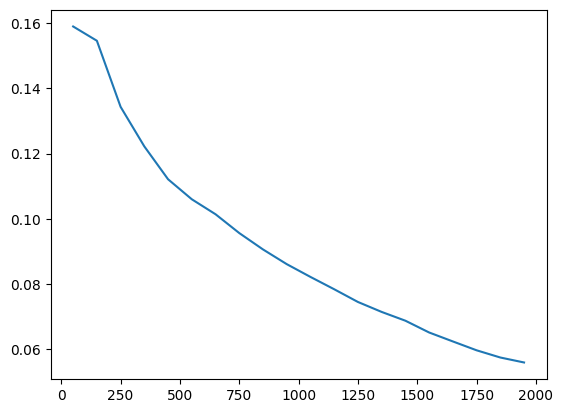

In [272]:
sns.lineplot(y = agg_distances, x = list(k_list))

## OPTICS

In [273]:
from sklearn.cluster import OPTICS

In [277]:
optics_clustering = OPTICS(min_samples=20, metric='cosine')

In [278]:
optics_clustering.fit(embeddings)

OPTICS(metric='cosine', min_samples=20)

In [279]:
cluster_labels = optics_clustering.labels_

In [283]:
np.unique(cluster_labels)

array([0])

## K-means on cosine similarities

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
%%time
cos_sim_embed = cosine_similarity(embeddings, embeddings[0:10,:])

CPU times: user 328 ms, sys: 109 ms, total: 437 ms
Wall time: 259 ms


In [25]:
cos_sim_embed.shape

(231637, 10)

In [26]:
%%time

# Fit K-means
km = KMeans(n_clusters=1000)

km.fit(cos_sim_embed)

CPU times: user 2min 59s, sys: 10.2 s, total: 3min 9s
Wall time: 58.3 s


KMeans(n_clusters=1000)

In [27]:
km.labels_

array([573, 244, 722, ..., 979, 409, 512], dtype=int32)

### with all columns of cosine

In [35]:
%time

inertias = []
ks = [100, 500, 1000, 2000, 5000, 10000]

for k in tqdm(ks):
    km_test = KMeans(n_clusters=k)
    km_test.fit(cos_sim_embed)
    inertias.append(km_test.inertia_)



CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.81 µs


100%|████████████████████████████████████████████████████████| 6/6 [12:57<00:00, 129.63s/it]


<Axes: >

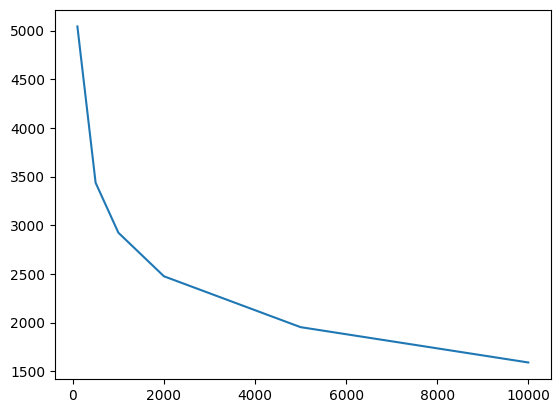

In [36]:
sns.lineplot(y = inertias, x = list(ks))

### with 1 colomn of Cosine

In [320]:
%%time

inertias = []
ks = range(50, 2000, 100)

for k in tqdm(ks):
    km_test = KMeans(n_clusters=k)
    km_test.fit(cos_sim_embed[:,0:1])
    inertias.append(km_test.inertia_)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.40it/s]

CPU times: user 20.2 s, sys: 17.6 s, total: 37.8 s
Wall time: 14.3 s


<AxesSubplot:>

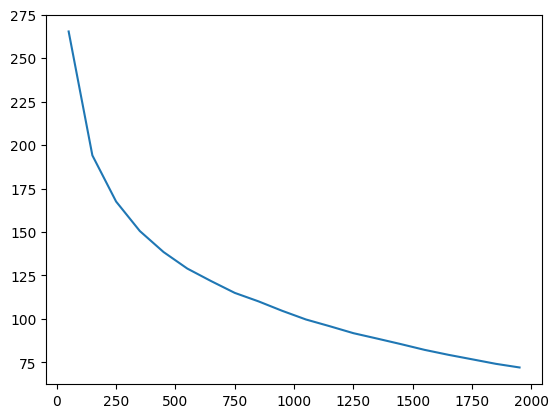

In [315]:
sns.lineplot(y = inertias, x = list(ks))

### With 10 column of cosine

In [321]:
%%time

inertias = []
ks = range(50, 2000, 100)

for k in tqdm(ks):
    km_test = KMeans(n_clusters=k)
    km_test.fit(cos_sim_embed[:,0:10])
    inertias.append(km_test.inertia_)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.09it/s]

CPU times: user 32.8 s, sys: 30.9 s, total: 1min 3s
Wall time: 18.4 s


<AxesSubplot:>

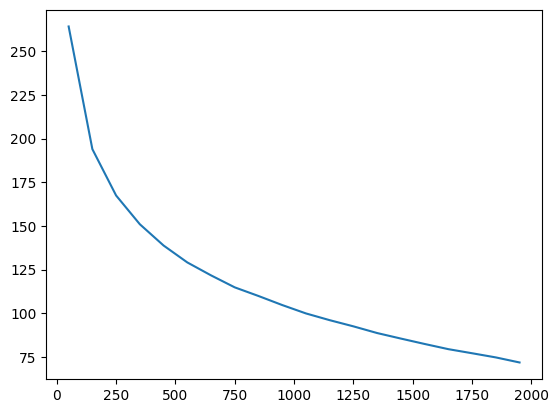

In [322]:
sns.lineplot(y = inertias, x = list(ks))

### With 100 column of cosine

In [323]:
%%time

inertias = []
ks = range(50, 2000, 100)

for k in tqdm(ks):
    km_test = KMeans(n_clusters=k)
    km_test.fit(cos_sim_embed[:,0:100])
    inertias.append(km_test.inertia_)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:28<00:00,  4.43s/it]

CPU times: user 4min 8s, sys: 6min 29s, total: 10min 37s
Wall time: 1min 28s


<AxesSubplot:>

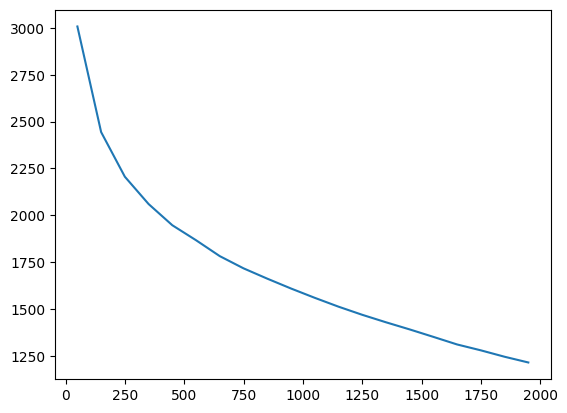

In [324]:
sns.lineplot(y = inertias, x = list(ks))

### Final Selected KMeans

In [37]:
%%time 

km_model_final = KMeans(n_clusters=5000)
km_model_final.fit(cos_sim_embed)
recipe_cluster_labels = km_model_final.labels_


CPU times: user 10min 57s, sys: 2min 9s, total: 13min 7s
Wall time: 3min 56s


In [28]:
km_model_final = km
recipe_cluster_labels = km.labels_

In [38]:
### Saving models & clusters by recipe

# Export labels as a file
with open("recipe_cluster_labels_5000.pkl", "wb") as file:
    pickle.dump(recipe_cluster_labels, file)

# Export Kmean model as a file
with open("km_model_5000_final.pkl", "wb") as file:
    pickle.dump(km_model_final, file)
